# Table of Contents

1. [Imports](#imports)
2. [Constants](#constants)
3. [Utils](#utils)
4. [Data preparation and exploration](#dataprep)  
    4.1 [Import data](#impdata)  
    4.2 [Set the index](#setind)  
    4.3 [Remove empty columns](#rmcols)  
    4.4 [Datatypes](#datatypes)  
    4.5 [Format Inspection Date](#inspdate)  
    4.6 [Format State](#state)  
    4.7 [Format City](#city)  
    4.8 [Format License # and Zip](#licnzip)  
    4.9 [Columns categorization](#colscateg)  
    4.10 [Format DBA Name and AKA Name](#names)  
    4.11 [Format Address](#addr)  
    4.12 [Format Latitude and Longitude](#latlong)   
    4.13 [Add Neighbourhood](#neigh)   
    4.14 [Extract Violations](#extrviols)  
    4.15 [Pickle the dataframes](#pickle)  
5. [Research questions](#research)  
    5.1 [Load pickled dataframes](#unpickle)  
    5.2 [Inspections' effects on establishments](#effects)  
    5.3 [Establishments' predispositions to inspection failure](#predispositions)  
    5.4 [Neighbourhood and food quality correlation](#neighbourhood)  
    5.5 [Violation analysis](#violation)  

**Remember**: the *Data preparation* and the *Pickle the dataframes* sections need to be executed only once. You can directly jump to the *Research questions* section if you already have the pickled dataframes.

# Imports

<a id="imports"></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import os
import pickle
import re
import neighborhoodize
from dateutil.parser import parse
from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

sns.set_context('notebook')

# Constants


<a id="constants"></a>

In [2]:
DATA_PATH = './data/food-inspections.csv'
PICKLED_DF_PATH = './data/df.pkl'
PICKLED_DF_VIOLATIONS_PATH = './data/df_violations.pkl'
#DEFAULT_ENCODING = 'UTF8'
#DEFAULT_COMPRESSION = 'gzip'

# Utils


<a id="utils"></a>

In [3]:
def show_all(df):
    """
    Prints the whole DataFrame given as parameter.
    :param df: pandas.DataFrame
    """
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df)

In [4]:
def nan_counts(df):
    """
    Returns the number of NaNs in the given dataframe.
    :param df: pandas.DataFrame
    """
    return len(df) - df.count()

# Data preparation and exploration


<a id="dataprep"></a>

## Import data


<a id="impdata"></a>

In [5]:
# Import the dataset, adding zero to the list of NaN values.
df = pd.read_csv(DATA_PATH, na_values=[0, 0.0])
df.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102,"{'longitude': '41.88935425192819', 'latitude':...",NaN,NaN,NaN,NaN,NaN
1,2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,...,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148,"{'longitude': '41.93901560699069', 'latitude':...",NaN,NaN,NaN,NaN,NaN
2,2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,...,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596,"{'longitude': '41.967671015100265', 'latitude'...",NaN,NaN,NaN,NaN,NaN


## Set the index


<a id="setind"></a>

The column `Inspection ID` should contain distinct values, and thus it represent a natural choice for the index of our dataframe. However, after a quick inspection, we found some duplicates, which we decided to remove.

In [6]:
df.drop_duplicates(subset=['Inspection ID'], inplace=True)
df = df.set_index('Inspection ID')
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,2019-10-16T00:00:00.000,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102,"{'longitude': '41.88935425192819', 'latitude':...",NaN,NaN,NaN,NaN,NaN
2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,2019-10-16T00:00:00.000,...,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148,"{'longitude': '41.93901560699069', 'latitude':...",NaN,NaN,NaN,NaN,NaN
2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,2019-10-16T00:00:00.000,...,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596,"{'longitude': '41.967671015100265', 'latitude'...",NaN,NaN,NaN,NaN,NaN


In [7]:
# The index is now unique
df.index.is_unique

True

## Remove empty columns

<a id="rmcols"></a>

Since the last 5 columns are empty, we decided to remove them. Moreover, the `Location` column contains redundant information, as we also have the columns `Latitude` and `Longitude`, so we dropped it as well.

In [8]:
# Drop 'Location' and the columns composed of only NaN values
df.drop(['Location', 'Historical Wards 2003-2015', 'Zip Codes', 'Community Areas', 'Census Tracts', 'Wards'], axis=1, inplace=True)
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,2019-10-16T00:00:00.000,License,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102
2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,2019-10-16T00:00:00.000,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148
2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,2019-10-16T00:00:00.000,Canvass,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596


Some columns have very few NaN values, which we drop here to ease the data preparation.

In [9]:
df.dropna(subset=['City', 'License #', 'Zip', 'Facility Type', 'Risk', 'Inspection Type', 'Results'], inplace=True)

## Datatypes

<a id="datatypes"></a>

Let's take a look at our dataframe's types.

In [10]:
df.dtypes

DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Results             object
Violations          object
Latitude           float64
Longitude          float64
dtype: object

We made the following observations:
- `License #` and `Zip` have type `float` but should indeed have type `int`. 
- `Facility Type`, `Risk`, `Inspection Type` and `Results` take only a finite number of discrete values, so they can be be categorized.
- `Inspection Date` have type `object` (i.e. a string), but should instead have a type reflecting the fact that it is an actual date.

## Format `Inspection Date`

<a id="inspdate"></a>

In [11]:
show_all(df['Inspection Date'].value_counts())

2013-11-14T00:00:00.000    179
2016-09-13T00:00:00.000    149
2016-11-29T00:00:00.000    145
2016-09-29T00:00:00.000    139
2016-09-26T00:00:00.000    138
2016-09-08T00:00:00.000    137
2016-08-18T00:00:00.000    136
2016-06-16T00:00:00.000    135
2016-10-04T00:00:00.000    135
2016-09-15T00:00:00.000    135
2016-09-30T00:00:00.000    133
2013-10-01T00:00:00.000    133
2016-09-09T00:00:00.000    133
2016-09-16T00:00:00.000    132
2017-03-21T00:00:00.000    132
2016-08-30T00:00:00.000    132
2011-03-28T00:00:00.000    131
2016-08-29T00:00:00.000    130
2016-05-03T00:00:00.000    130
2018-06-05T00:00:00.000    130
2016-05-26T00:00:00.000    129
2010-06-07T00:00:00.000    129
2017-09-14T00:00:00.000    129
2015-09-29T00:00:00.000    128
2016-10-05T00:00:00.000    128
2013-09-09T00:00:00.000    127
2017-09-08T00:00:00.000    127
2015-09-24T00:00:00.000    127
2016-10-25T00:00:00.000    127
2017-06-08T00:00:00.000    127
2017-06-06T00:00:00.000    126
2015-09-03T00:00:00.000    126
2011-02-

In [12]:
# Remove useless information in date and transform it into a datetime64 object
df['Inspection Date'] = df['Inspection Date'].apply(lambda x: parse(x[:10]))
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2315925,EXOS WORKS,EXOS WORKS,2658207.0,Restaurant,Risk 1 (High),401 N MICHIGAN AVE,CHICAGO,IL,60611.0,2019-10-16,License,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.889354,-87.624102
2315916,INTRINSIC CHARTER SCHOOL,INTRINSIC CHARTER SCHOOL,3305837.0,School,Risk 1 (High),4540 W BELMONT AVE,CHICAGO,IL,60641.0,2019-10-16,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.939016,-87.741148
2315931,STARBUCKS COFFEE #49894,STARBUCKS,2621807.0,Restaurant,Risk 2 (Medium),5601 W LAWRENCE AVE,CHICAGO,IL,60630.0,2019-10-16,Canvass,Pass w/ Conditions,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",41.967671,-87.767596


In [13]:
# The 'Inspection Date' type is now datetime64.
df.dtypes

DBA Name                   object
AKA Name                   object
License #                 float64
Facility Type              object
Risk                       object
Address                    object
City                       object
State                      object
Zip                       float64
Inspection Date    datetime64[ns]
Inspection Type            object
Results                    object
Violations                 object
Latitude                  float64
Longitude                 float64
dtype: object

We decided to to deal with the changes to food inspections procedures that happened on July 1st, 2018 by removing entries corresponding to subsequent dates.

In [14]:
df = df[df['Inspection Date'] < datetime(2018, 7, 1)]

In [15]:
df.sort_values('Inspection Date', ascending=False).head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056.0,Restaurant,Risk 1 (High),7026 W ARCHER AVE,CHICAGO,IL,60638.0,2018-06-29,Complaint,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182154,THE GOOD LIFE SOUL FOOD RESTAURANT,THE GOOD LIFE SOUL FOOD RESTAURANT,2551347.0,Restaurant,Risk 1 (High),11142 S HALSTED ST,CHICAGO,IL,60628.0,2018-06-29,Canvass Re-Inspection,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.691077,-87.642490
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662.0,Long Term Care,Risk 1 (High),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644.0,2018-06-29,Canvass Re-Inspection,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745


## Format `State`

<a id="state"></a>

Let's take a look at the counts of unique values in the column `State`:

In [16]:
df['State'].value_counts() 

IL    167536
Name: State, dtype: int64

All the facilities are located in the state of Illinois.

## Format `City`

<a id="city"></a>

Let's take a look at the counts of unique values in the column `City`:

In [17]:
df['City'].value_counts()

CHICAGO                 166937
Chicago                    282
chicago                     88
CCHICAGO                    41
SCHAUMBURG                  22
MAYWOOD                     15
ELK GROVE VILLAGE           13
CHicago                     11
EVANSTON                    10
CICERO                       9
CHESTNUT STREET              9
SKOKIE                       8
INACTIVE                     7
CHCHICAGO                    6
NILES NILES                  6
ELMHURST                     5
WORTH                        5
CALUMET CITY                 5
OAK PARK                     5
CHICAGOCHICAGO               4
CHARLES A HAYES              4
SUMMIT                       4
CHICAGOI                     3
SCHILLER PARK                3
ALSIP                        3
BRIDGEVIEW                   3
EAST HAZEL CREST             3
CHCICAGO                     3
BLUE ISLAND                  2
BEDFORD PARK                 2
BANNOCKBURNDEERFIELD         2
NAPERVILLE                   2
CHICAGO 

We can see different entries corresponding to the same city, such as "CHICACOCHICAGO" and "CHicago". We thus have to normalize them in order to have a unique format.

The rows containing "INACTIVE" should instead be removed.

In [18]:
def normalize_city(city):
    """
    Normalizes the given city name, converting all lowercase characters into uppercase characters and 
    transforming it to the right format.
    :param city: string
    :return: string
    """
    normalized = city.upper()
    if ('CHICAGO' in normalized and ' ' not in normalized) or 'CHCICAGO' == normalized:
        normalized = 'CHICAGO'
    elif 'OOLYMPIA FIELDS' == normalized:
        normalized = 'OLYMPIA FIELDS'
    
    return normalized

In [19]:
df = df[df['City'] != 'INACTIVE']
df['City'] = df['City'].apply(normalize_city)
df['City'].value_counts()

CHICAGO                 167378
SCHAUMBURG                  22
MAYWOOD                     16
ELK GROVE VILLAGE           13
EVANSTON                    10
CHESTNUT STREET              9
CICERO                       9
SKOKIE                       8
NILES NILES                  6
WORTH                        5
ELMHURST                     5
CALUMET CITY                 5
OAK PARK                     5
SUMMIT                       4
CHARLES A HAYES              4
BRIDGEVIEW                   3
SCHILLER PARK                3
ALSIP                        3
EAST HAZEL CREST             3
BANNOCKBURNDEERFIELD         2
STREAMWOOD                   2
NAPERVILLE                   2
CHICAGO HEIGHTS              2
BLUE ISLAND                  2
BERWYN                       2
BEDFORD PARK                 2
COUNTRY CLUB HILLS           1
BROADVIEW                    1
LOMBARD                      1
NORRIDGE                     1
EVERGREEN PARK               1
OAK LAWN                     1
FRANKFOR

In [20]:
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056.0,Restaurant,Risk 1 (High),7026 W ARCHER AVE,CHICAGO,IL,60638.0,2018-06-29,Complaint,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662.0,Long Term Care,Risk 1 (High),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644.0,2018-06-29,Canvass Re-Inspection,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521.0,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616.0,2018-06-29,License,No Entry,NaN,41.855282,-87.631993


## Format `License #` and `Zip`

<a id="licnzip"></a>

In [21]:
# We cast them to int64
df[['License #', 'Zip']] = df[['License #', 'Zip']].astype(np.int64)
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,Restaurant,Risk 1 (High),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,Complaint,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,Long Term Care,Risk 1 (High),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,Canvass Re-Inspection,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,License,No Entry,NaN,41.855282,-87.631993


In [22]:
df.dtypes

DBA Name                   object
AKA Name                   object
License #                   int64
Facility Type              object
Risk                       object
Address                    object
City                       object
State                      object
Zip                         int64
Inspection Date    datetime64[ns]
Inspection Type            object
Results                    object
Violations                 object
Latitude                  float64
Longitude                 float64
dtype: object

## Columns categorization

<a id="colscateg"></a>

In [23]:
# Transform each value to its upper case version and cast it to a categorical representation.
for col in ['Facility Type', 'Risk', 'Inspection Type', 'Results']:
    df[col] = df[col].apply(lambda x: x.upper()).astype('category')
    
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,NaN,41.855282,-87.631993


In [24]:
df.dtypes

DBA Name                   object
AKA Name                   object
License #                   int64
Facility Type            category
Risk                     category
Address                    object
City                       object
State                      object
Zip                         int64
Inspection Date    datetime64[ns]
Inspection Type          category
Results                  category
Violations                 object
Latitude                  float64
Longitude                 float64
dtype: object

## Format `DBA Name` and `AKA Name`

<a id="names"></a>

The two columns are transformed to upper case. 

In [25]:
df['DBA Name'] = df['DBA Name'].apply(lambda x: x.upper())

Let's see what are the most frequent DBA names among the establishments present in the dataframe.

In [26]:
df[['DBA Name', 'License #']].drop_duplicates()['DBA Name'].value_counts().head(60)

SUBWAY                                               289
DUNKIN DONUTS                                        172
7-ELEVEN                                              76
MCDONALD'S                                            59
TRIPLE A SERVICES, INC.                               49
CITGO                                                 39
GATEWAY NEWSTAND                                      38
MCDONALDS                                             31
AU BON PAIN                                           31
PIZZA HUT                                             31
CHARTWELLS                                            30
MARATHON                                              30
CHIPOTLE MEXICAN GRILL                                29
DOMINO'S PIZZA                                        28
WHOLE FOODS MARKET                                    26
DUNKIN DONUTS/BASKIN ROBBINS                          24
KENTUCKY FRIED CHICKEN                                24
KFC                            

There are a lot of establishments that share the same name because of the presence of restaurant chains in the dataset. Let's clean this a bit.

In [27]:
clean_names = {
    "SUBWAY SANDWICHES": "SUBWAY",
    "DUNKIN DONUTS/BASKIN ROBBINS": "DUNKIN DONUTS",
    "DUNKIN DONUTS BASKIN ROBBINS": "DUNKIN DONUTS",
    "MCDONALDS": "MCDONALD'S",
    "MC DONALD'S": "MCDONALD'S",
    "CITGO FUEL & MINI MART": "CITGO",
    "KENTUCKY FRIED CHICKEN": "KFC",
    "JIMMY JOHNS": "JIMMY JOHN'S",
    "POTBELLY SANDWICH WORKS LLC": "POTBELLY SANDWICH WORKS",
    "HAROLD'S CHICKEN": "HAROLD'S CHICKEN SHACK"
}

df['DBA Name'] = df['DBA Name'].apply(lambda n: clean_names.get(n, n))
df[['DBA Name', 'License #']].drop_duplicates()['DBA Name'].value_counts().head(60)

SUBWAY                                               309
DUNKIN DONUTS                                        207
MCDONALD'S                                           102
7-ELEVEN                                              76
CITGO                                                 52
TRIPLE A SERVICES, INC.                               49
KFC                                                   47
JIMMY JOHN'S                                          38
GATEWAY NEWSTAND                                      38
POTBELLY SANDWICH WORKS                               37
PIZZA HUT                                             31
HAROLD'S CHICKEN SHACK                                31
AU BON PAIN                                           31
CHARTWELLS                                            30
MARATHON                                              30
CHIPOTLE MEXICAN GRILL                                29
DOMINO'S PIZZA                                        28
WHOLE FOODS MARKET             

`DBA Name` contains no NaNs, while `AKA Name` contains some: we decided to replace them with the corresponding value in the first column.

In [28]:
df['AKA Name'] = df['AKA Name'].fillna(df['DBA Name']).apply(lambda x: x.upper())
df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,NaN,41.855282,-87.631993


## Format `Address`

<a id="addr"></a>

In [29]:
df['Address'] = df['Address'].apply(lambda x: x.upper())

df.head(3)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.792140,-87.797669
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.876564,-87.753745
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,NaN,41.855282,-87.631993


## Format `Latitude` and `Longitude`

<a id="latlong"></a>

These two columns already have the right type, `float64`, so we only have to deal with missing values.

In [30]:
nan_counts(df['Latitude'])

576

In [31]:
nan_counts(df['Longitude'])

576

Luckily for us, they have the same number of NaNs, 576, and they always come paired together. Since we have for each entry the address, we impute these missing values by computing latitude and longitude given the address.

In [32]:
geolocator = Nominatim(user_agent='ADA-project', timeout=10)
def compute_coordinates(row):
    """
    Computes and updates the coordinates of the given row if they are NaN.
    :param row: pandas.Series
    :return: pandas.Series
    """
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    if pd.isna(latitude) and pd.isna(longitude):
        address = "{} {}".format(row['Address'], row['City'])
        location = geolocator.geocode(address)
        if location:
            row['Latitude'] = location.latitude
            row['Longitude'] = location.longitude
            
    return row

In [33]:
df = df.apply(compute_coordinates, axis=1)

In [34]:
nan_counts(df['Latitude'])

411

In [35]:
nan_counts(df['Longitude'])

411

We still have some missing values, probably due to the fact that the corresponding addresses are ill-formed and thus it is impossible to infer the coordinates. We decided to drop them, as they are relatively rare.

In [36]:
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

## Add `Neighbourhood`

<a id="neigh"></a>

We need to know the neighbourhood in which each facility is located to answer some research questions later. Thus, we extract, based on the latitude and longitude, the corresponding neighbourhood, creating a new column.

In [37]:
hood_map = neighborhoodize.NeighborhoodMap(neighborhoodize.zillow.ILLINOIS)

def get_neighbourhood(row):
    """
    Gets the neighbourhood of the facility corresponding to the given row. 
    Returns np.nan if no neighbourhood has been found.
    :param row: pandas.Series
    :return: string
    """
    hoods = hood_map.get_neighborhoods(row['Latitude'], row['Longitude'])
    if hoods:
        return hoods[0].upper()
    
    return np.nan

In [38]:
df['Neighbourhood'] = df.apply(get_neighbourhood, axis=1)

In [39]:
df['Neighbourhood'].value_counts()

NEAR NORTH SIDE    12363
LOOP               11391
NEAR WEST SIDE      9348
LAKE VIEW           8557
WEST TOWN           7616
                   ...  
FULLER PARK          330
PULLMAN              233
RIVERDALE            154
OAKLAND              127
BURNSIDE              19
Name: Neighbourhood, Length: 77, dtype: int64

There are 77 different neighbourhoods, which is precisely the number of community areas in which the City of Chicago is divided.

In [40]:
nan_counts(df['Neighbourhood'])

2857

There are some missing entries in this column too, unfortunately. We thus decided to impute them using a K-Nearest Neighbors classifier.

In [41]:
df_with_hoods = df[~df['Neighbourhood'].isna()]
df_without_hoods = df[df['Neighbourhood'].isna()]

X = df_with_hoods[['Latitude', 'Longitude']]
y = df_with_hoods['Neighbourhood']

In [42]:
knn = KNeighborsClassifier()

# Creates a dictionary of all values we want to test for k
param_grid = {'n_neighbors': np.arange(1, 20)}

# Uses grid search to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

# Fits model to data
knn_gscv.fit(X, y)

# Checks top performing n_neighbors value
best_k = knn_gscv.best_params_['n_neighbors']

print(f'Best k is {best_k} with mean score {knn_gscv.best_score_}')

Best k is 1 with mean score 0.9990686292413894


In [43]:
neigh = KNeighborsClassifier(n_neighbors=best_k)

neigh.fit(X, y) 

predictions = neigh.predict(df_without_hoods[['Latitude', 'Longitude']])

df.loc[df['Neighbourhood'].isna(), 'Neighbourhood'] = predictions

In [44]:
nan_counts(df['Neighbourhood'])

0

## Extract `Violations`

<a id="extrviols"></a>

In [45]:
parsed_violations = []

# For every inspection, extract each violation and its associated comment
for index, row in df.iterrows():
    if row['Violations'] is not np.nan:
        for violation in row['Violations'].split(' | '):
            violation_and_comment = violation.split(' - Comments: ')
            
            violation_id = violation_and_comment[0]
            comment = violation_and_comment[1] if len(violation_and_comment) > 1 else np.nan
            
            parsed_violations.append([index, violation_id, comment])

# Create new dataframe containing the violations
df_violations = pd.DataFrame(parsed_violations, columns=['Inspection ID', 'Violation', 'Comment']) 
df_violations = df_violations.set_index('Inspection ID')

# The column 'Violations' is now useless and can be deleted
df = df.drop(columns=['Violations'])
df.head(10)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,Neighbourhood
Inspection ID,,,,,,,,,,,,,,,
2182172,PEPE'S RESTAURANT,PEPE'S RESTAURANT,7056,RESTAURANT,RISK 1 (HIGH),7026 W ARCHER AVE,CHICAGO,IL,60638,2018-06-29,COMPLAINT,PASS,41.792140,-87.797669,GARFIELD RIDGE
2182156,COLUMBUS MANOR RESIDENTIAL CARE & HOME,COLUMBUS MANOR RESIDENTIAL CARE & HOME,2418662,LONG TERM CARE,RISK 1 (HIGH),5107-5121 W JACKSON BLVD,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,PASS,41.876564,-87.753745,AUSTIN
2182153,SHAN SHAAN TASTE,SHAN SHAAN TASTE,2608521,RESTAURANT,RISK 1 (HIGH),2002 S WENTWORTH AVE,CHICAGO,IL,60616,2018-06-29,LICENSE,NO ENTRY,41.855282,-87.631993,ARMOUR SQUARE
2182160,CASA HERNANDEZ,CASA HERNANDEZ GROCERY STORE,1047126,GROCERY STORE,RISK 1 (HIGH),1725 W LUNT,CHICAGO,IL,60626,2018-06-29,CANVASS RE-INSPECTION,PASS,42.008897,-87.673311,ROGERS PARK
2182174,ACAPULCO BAKERY #2 INC.,ACAPULCO BAKERY #2,2602082,BAKERY,RISK 2 (MEDIUM),6044 W 63RD ST,CHICAGO,IL,60638,2018-06-29,LICENSE,PASS,41.777938,-87.773289,CLEARING
2182169,"JOE'S BARBQUE, INC",JOE'S BARBQUE,18234,RESTAURANT,RISK 1 (HIGH),4900 W MADISON ST,CHICAGO,IL,60644,2018-06-29,CANVASS RE-INSPECTION,FAIL,41.880571,-87.747957,AUSTIN
2182165,WHIPPED & BEATEN CULINARY WORKS,WHIPPED & BEATEN CULINARY WORKS,2590079,COOKING SCHOOL,RISK 1 (HIGH),3611-3617 N BROADWAY,CHICAGO,IL,60613,2018-06-29,LICENSE RE-INSPECTION,PASS,41.947732,-87.647343,LAKE VIEW
2182159,J & R COCKTAIL LOUNGE,J & R COCKTAIL LOUNGE,946,LIQUOR,RISK 3 (LOW),612 E 79TH ST,CHICAGO,IL,60619,2018-06-29,COMPLAINT RE-INSPECTION,PASS,41.751319,-87.609522,GRAND CROSSING
2182161,MCDONALDS RESTAURANT,MCDONALDS RESTAURANT,2384975,RESTAURANT,RISK 2 (MEDIUM),3154 W FOSTER AVE,CHICAGO,IL,60625,2018-06-29,SHORT FORM COMPLAINT,PASS,41.975860,-87.708465,NORTH PARK


The column `Violation` can also be categorized since it contains only 46 distinct values.

In [46]:
df_violations['Violation'] = df_violations['Violation'].astype('category')
df_violations.head(10)

,Violation,Comment
Inspection ID,,
2182172,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,OBSERVED THE CUTTING BOARDS AT HOT HOLDING TAB...
2182172,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"OBSERVED THE FOLOWING NOT CLEAN, SLICER, CHOPE..."
2182172,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",OBSERVED THE FLOOR BEHIND THE COOKING EQUIPMEN...
2182172,39. LINEN: CLEAN AND SOILED PROPERLY STORED,OBSERVED IMPROPER STORAGE OF WIPING CLOTHES ON...
2182172,"41. PREMISES MAINTAINED FREE OF LITTER, UNNECE...",OBSERVED FOOD NOT ELEVATED 6' OF THE WALK-IN C...
2182156,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,DETAIL CLEAN THE STORAGE CABINETS ATTACHED TO ...
2182160,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,OBSERVED PACKAGING TABLE NEAR MOP SINK WITH PE...
2182160,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,OBSERVED REACH IN CHEST FREEZER UNCLEAN WITH F...
2182160,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",OBSERVED FLOORS AROUND MOP SINK AND UNDER ADJA...


In [47]:
df_violations.dtypes

Violation    category
Comment        object
dtype: object

## Pickle the dataframes

<a id="pickle"></a>

We save the two dataframes to pickle files to avoid cleaning the data every time.

In [48]:
df.to_pickle(PICKLED_DF_PATH)
df_violations.to_pickle(PICKLED_DF_VIOLATIONS_PATH)

# Research questions

<a id="research"></a>

## Load pickled dataframes

<a id="unpickle"></a>

Let's load the pickled dataframes from the file system.

In [49]:
df = pd.read_pickle(PICKLED_DF_PATH)
df_violations = pd.read_pickle(PICKLED_DF_VIOLATIONS_PATH)

## Inspections' effects on establishments

<a id="effects"></a>

### Does an inspection have a positive effect on the future inspections? i.e. does inspecting increase an establishment’s quality?

First, let's just analyze the overall aspect of the `results` field.

In [50]:
df['Results'].value_counts()

PASS                    100246
FAIL                     32929
PASS W/ CONDITIONS       16398
OUT OF BUSINESS          11273
NO ENTRY                  5074
NOT READY                 1176
BUSINESS NOT LOCATED        35
Name: Results, dtype: int64

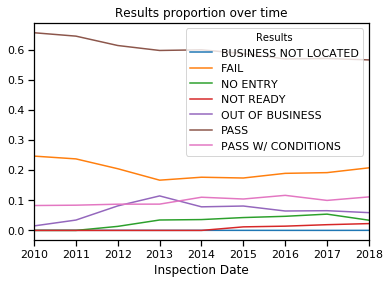

In [101]:
df_results = df.groupby([df['Inspection Date'].dt.year, df['Results']])['Results'].count().unstack().fillna(0)
df_results = df_results.div(df_results.sum(axis=1), axis=0)
df_results.plot(title='Results proportion over time')

It seems that the inspections' passing rate is decreasing through time. This could be a clue that inspecting does not actually increase establishments' quality, but let's investigate further.

First, we compare the percentage for each result in case of re-inspection and the one in case of (first) inspection.

In [52]:
df_reinspected = df[df['Inspection Type'].str.contains('(RE).?(INSPECTION)', regex=True)]['Results']
print(len(df_reinspected))

reinspected_results = df_reinspected.value_counts() / len(df_reinspected)
# We do not care about the OUT OF BUSINESS, NOT LOCATED and NO ENTRY results
interest = ['PASS', 'FAIL', 'PASS W/ CONDITIONS']
reinspected_pass = reinspected_results[interest] / reinspected_results[interest].sum(axis=0) * 100
reinspected_pass

32449


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


PASS                  86.219478
FAIL                   8.282658
PASS W/ CONDITIONS     5.497864
Name: Results, dtype: float64

In [53]:
df_other_inspections= df[np.logical_not(mask)]['Results']
print(len(df_other_inspections))

inspected_results = df_other_inspections.value_counts() / len(df_other_inspections)
inspected_pass = inspected_results[interest] / inspected_results[interest].sum(axis=0) * 100
inspected_pass

134682


PASS                  61.782377
FAIL                  25.762940
PASS W/ CONDITIONS    12.454683
Name: Results, dtype: float64

Here, we don't consider special inspection results (out of business, no entry, not located), as they don't have any reinspection follow-up. Consequently, we don't consider the reinspections yielding those specials results, to remain consistant in our statistics comparison.

In [54]:
reinspected_pass - inspected_pass

PASS                  24.437101
FAIL                 -17.480282
PASS W/ CONDITIONS    -6.956819
Name: Results, dtype: float64

We get an increase of $24.4\%$ of the pass rate between inspections and re-inspections along with a decrease of $17.5\%$ of the fail rate. So it seems that inspecting increases quite a lot the quality of the establishments. 

### Are inspections requested by the establishments usually favorable?

Let's first take a look at the result distribution of this kind of inspection.

In [55]:
df_consults = df[df['Inspection Type'] == 'CONSULTATION']['Results']
df_consults = df_consults.value_counts() / len(df_consults) * 100
df_consults

PASS                    63.509317
PASS W/ CONDITIONS      18.788820
FAIL                    15.527950
NO ENTRY                 0.931677
NOT READY                0.621118
OUT OF BUSINESS          0.465839
BUSINESS NOT LOCATED     0.155280
Name: Results, dtype: float64

For comparison, the same computation is done on the other types of inspection.

In [56]:
df_nonconsults = df[df['Inspection Type'] != 'CONSULTATION']['Results']
df_nonconsults = df_nonconsults.value_counts() / len(df_nonconsults) * 100
df_nonconsults

PASS                    59.966844
FAIL                    19.718657
PASS W/ CONDITIONS       9.776739
OUT OF BUSINESS          6.769297
NO ENTRY                 3.044082
NOT READY                0.703959
BUSINESS NOT LOCATED     0.020422
Name: Results, dtype: float64

In [58]:
(df_consults - df_nonconsults).sort_values(ascending=False)

PASS W/ CONDITIONS      9.012081
PASS                    3.542473
BUSINESS NOT LOCATED    0.134857
NOT READY              -0.082841
NO ENTRY               -2.112405
FAIL                   -4.190706
OUT OF BUSINESS        -6.303459
Name: Results, dtype: float64

On average, inspections requested by the establishments have a significantly higher success rate as well as a lower failing rate. Indeed, expecting an inspection intuitevely increases the success rate because the owner is more likely to be prepared for it.

### What is the evolution of the overall inspection frequency over the last decade?

[Text(0.5, 0, 'Year, Month')]

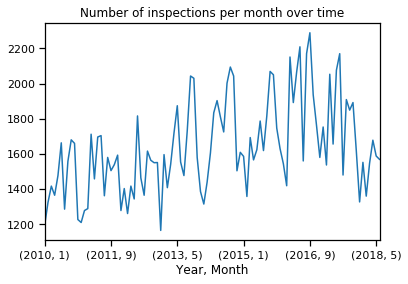

In [105]:
ax = df['Inspection Date'].groupby([df['Inspection Date'].dt.year, df['Inspection Date'].dt.month]).agg('count') \
    .plot(title='Number of inspections per month over time')
ax.set(xlabel='Year, Month')

This plot is very noisy, as the distribution of the number of inspections varies a lot from one month to the other. We try to plot the overall number of inspections per month to see if there is a tendency throughout the year.

[Text(0.5, 0, 'Month')]

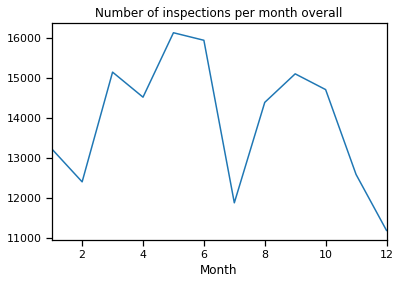

In [107]:
ax = df['Inspection Date'].groupby(df['Inspection Date'].dt.month).agg('count') \
    .plot(title='Number of inspections per month overall')
ax.set(xlabel='Month')

Indeed, we notice that during summer and winter holidays the number of inspections drops heavily.

[Text(0.5, 0, 'Year')]

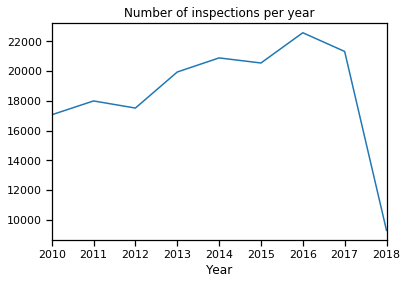

In [108]:
ax = df['Inspection Date'].groupby(df['Inspection Date'].dt.year).agg('count') \
    .plot(title='Number of inspections per year')
ax.set(xlabel='Year')

In [63]:
df['Inspection Date'].groupby(df['Inspection Date'].dt.year).agg('count').head(10)

Inspection Date
2010    17063
2011    17994
2012    17516
2013    19938
2014    20886
2015    20544
2016    22577
2017    21320
2018     9293
Name: Inspection Date, dtype: int64

This plot tell us quite a lot of things. First of all, the number of inspections has significanty increased from 2010 to 2016, passing from 17000 to more than 22000 inspections per year. We notice a small drop between 2016 and 2017. 

Year 2018 is incomplete as it only takes into account the inspections up to July 1st, so we theorically only have half the inspections for 2018 in our dataset. Following this assumption though, there should also be a drop between 2017 and 2018 as there has been less than 10000 inspections so far.

## Establishments' predispositions to inspection failure

<a id="predispositions"></a>

### Which facility type is more likely to fail?

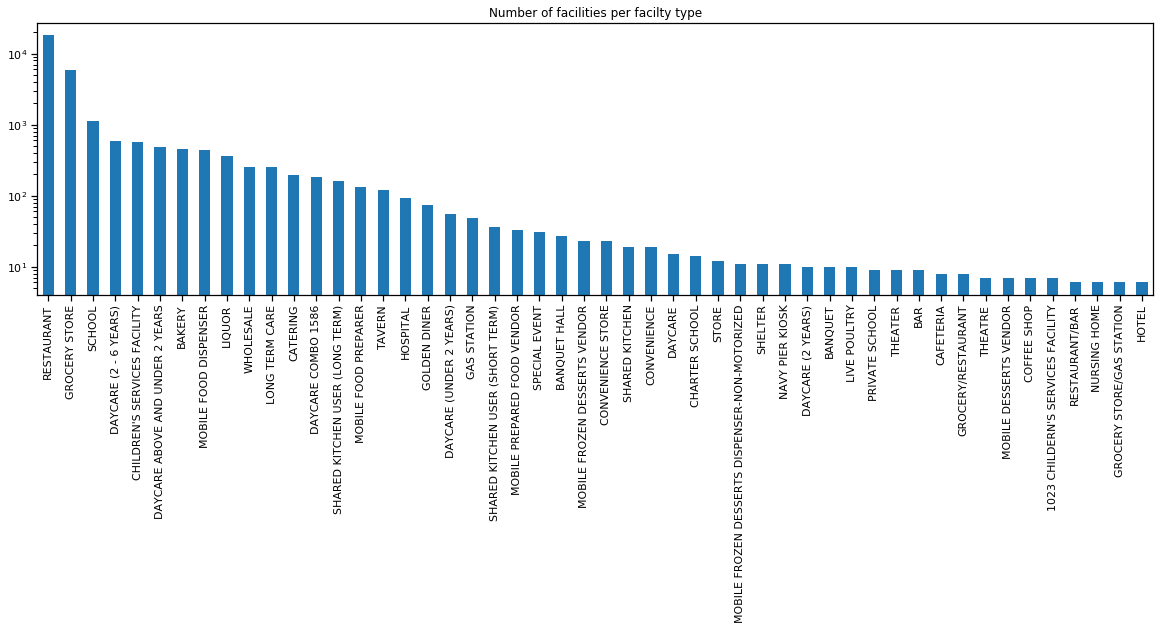

In [113]:
df.drop_duplicates('License #')['Facility Type'].value_counts().head(50).plot(kind='bar', logy=True, \
                                                 figsize=(20, 5), title='Number of facilities per facilty type')

In [65]:
# Filter out facility types that occur less than 50 times in the dataset
df_facility_results = df.groupby('Facility Type').filter(lambda x: x['Facility Type'].count() > 50)

# For each facility type, compute the result frequencies
df_facility_results = df_facility_results.groupby(['Facility Type', 'Results'])['Results'].count().unstack().fillna(0)

# Normalize the frequencies in order to have comparable proportions
df_facility_results = df_facility_results['FAIL'] / df_facility_results.sum(axis=1)

# Print the 20 facility types with the highest fail rate
df_facility_results.sort_values(ascending=False).head(20)

Facility Type
LIQUOR                         0.359844
WHOLESALE                      0.340426
TAVERN                         0.336957
MOBILE FOOD PREPARER           0.300797
MOBILE FOOD DISPENSER          0.291349
LIVE POULTRY                   0.285714
GAS STATION                    0.269841
CONVENIENCE STORE              0.250000
MOBILE PREPARED FOOD VENDOR    0.240000
DAYCARE COMBO 1586             0.238429
GROCERY STORE                  0.237494
SPECIAL EVENT                  0.229167
KIOSK                          0.215686
BANQUET HALL                   0.215278
BANQUET                        0.214286
DAYCARE (UNDER 2 YEARS)        0.213636
LONG TERM CARE                 0.213420
BAKERY                         0.210463
DAYCARE (2 - 6 YEARS)          0.198262
SCHOOL                         0.194135
dtype: float64

It appears that three facility types in particular have a higher failure rate than the rest:
   - the liquor stores
   - the wholesale distributors
   - the taverns and bars
   
A way of interpreting this would be to notice that when the main sold item is alcohol less care is taken in making the facilities clean and safe. As for wholesale distributors, their size and the fact that they are mostly used by companies rather than individuals could explain a lack of neatness.

Moreover, for taverns, it could also be harder to keep it as clean as other establishments because of drunk clients who could drop liquid on the floor and dirty the toilets up, for example.

### Compare the inspection results of the different fast-food restaurant chains against themselves or other restaurants.

Here, two ways of reaching our goal are proposed. The first one creates the actual dataframe, the other only displays the graph for biggest restaurant chains.

In [75]:
df[['DBA Name', 'License #']].drop_duplicates()['DBA Name'].value_counts().head(10)

SUBWAY                     306
DUNKIN DONUTS              206
MCDONALD'S                 102
7-ELEVEN                    76
CITGO                       52
TRIPLE A SERVICES, INC.     49
KFC                         47
GATEWAY NEWSTAND            38
JIMMY JOHN'S                38
POTBELLY SANDWICH WORKS     37
Name: DBA Name, dtype: int64

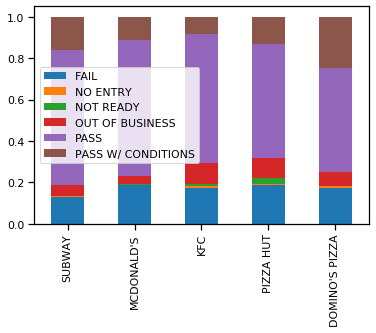

In [81]:
def get_chain_results(chain_name):
    '''
    Returns the results counts (as a percentage) for a specific food chain.
    :param chain_name: string, the food chain name we are interested in
    :return: pandas.DataFrame, a single-row dataframe where the columns are the result types and the cells contain
             the percentage of inspections with each type of result for the given food chain
    '''
    df_chain = df[df['DBA Name'] == chain_name]['Results']
    return (df_chain.value_counts() / df_chain.size).rename(chain_name).to_frame().transpose()

df_subway = get_chain_results("SUBWAY")
df_mcdonalds = get_chain_results("MCDONALD'S")
df_kfc = get_chain_results("KFC")
df_pizza_hut = get_chain_results("PIZZA HUT")
df_dominos_pizza = get_chain_results("DOMINO'S PIZZA")

df_chain_results = pd.concat([df_subway, df_mcdonalds, df_kfc, df_pizza_hut, df_dominos_pizza], sort=True)
df_chain_results.plot(kind='bar', stacked=True)

In [78]:
df_chain_results

,FAIL,NO ENTRY,NOT READY,OUT OF BUSINESS,PASS,PASS W/ CONDITIONS
SUBWAY,0.131298,0.001839,0.003310,0.048915,0.653549,0.161089
MCDONALD'S,0.187983,0.001717,0.004292,0.038627,0.654077,0.113305
KFC,0.174074,0.007407,0.011111,0.100000,0.625926,0.081481
PIZZA HUT,0.185185,0.007407,0.029630,0.096296,0.548148,0.133333
DOMINO'S PIZZA,0.174863,0.005464,NaN,0.071038,0.502732,0.245902


We chose to compare five well-known fast-food restaurant chains, namely `Subway`, `McDonald's`, `KFC`, `Pizza Hut` and `Domino's Pizza`. We chose these chains in particular as they are part of the [ten largest fast-food restaurant chains in the world](https://en.wikipedia.org/wiki/List_of_the_largest_fast_food_restaurant_chains). We used a barplot for comparison, as it appeared to be the most adequate plot to visualize the differences between the results of each chain.

The chain with the highest failure rate is `McDonald's`, closely followed by `Pizza Hut`, which has however a significantly lower number of facilities (31 versus 102 `McDonald's`). `Pizza Hut` also shares with `KFC` the highest out-of-business rate. As for `Domino's Pizza`, it has the lowest pass rate among the five but the highest pass with conditions rate. `Subway` appears to be the neatest restaurant chain among them since it has the highest `Pass` and `Pass with condition` rate.

We may have to be careful with those results: the huge gap (302 `Subway`'s versus only 28 `Domino's Pizza`) between the number of facilities could make the comparison biased.

## Neighbourhood and food quality correlation

<a id="neighbourhood"></a>

### How are the inspection results evolving over time and space?

To ease our work, we extract each inspection date's year and construct a new column `Year`.

Then, we group by `Neighbourhood` and `Year`, retaining only the `Results` column.

In [116]:
df_results = df.groupby([df['Neighbourhood'], df['Inspection Date'].dt.year])['Results'].value_counts().unstack().fillna(0)
df_results = df_results.apply(lambda x: x.astype(int))
df_results

Results                        BUSINESS NOT LOCATED  FAIL  NO ENTRY  \
Neighbourhood Inspection Date                                         
ALBANY PARK   2010                                0   119         0   
              2011                                0    59         0   
              2012                                0    47        10   
              2013                                0    48        10   
              2014                                0    55         8   
...                                             ...   ...       ...   
WOODLAWN      2014                                0    16         4   
              2015                                0    41         2   
              2016                                0    16         5   
              2017                                0     9         4   
              2018                                0     7         0   

Results                        NOT READY  OUT OF BUSINESS  PASS  \
Neighbourhood Inspection Date                                     
ALBANY PARK   2010                     0                6   179   
              2011                     0               41   176   
              2012                     0               35   181   
              2013                     0               31   200   
              2014                     0               31   265   
...                                  ...              ...   ...   
WOODLAWN      2014                     0                9    66   
              2015                     2               17    53   
              2016                     1                5    46   
              2017                     1                9    45   
              2018                     1                3    18   

Results                        PASS W/ CONDITIONS  
Neighbourhood Inspection Date                      
ALBANY PARK   2010                             19  
              2011                             31  
              2012                             30  
              2013                             38  
              2014                             30  
...                                           ...  
WOODLAWN      2014                              3  
              2015                              9  
              2016                              9  
              2017                              1  
              2018                              1  

[692 rows x 7 columns]

As it would be very cumbersome to draw a plot for each neighbourhood, we only plot the number of inspections and their results throughout the years for one sample neighbourhood.

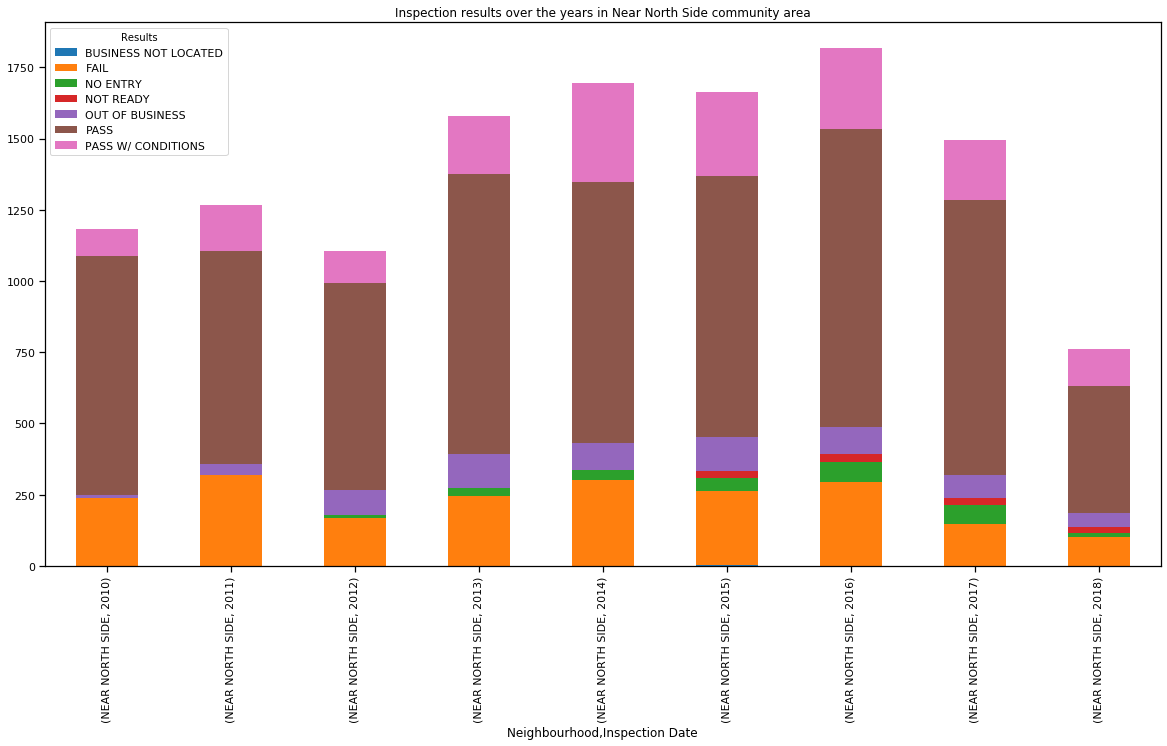

In [124]:
df_results.loc[['NEAR NORTH SIDE']].plot(kind='bar', stacked=True, figsize=(20, 10), \
                                               title='Inspection results over the years in Near North Side community area')

We will go further in our analysis when we will design our data story, using interactive plots and maps.

### Is there a relationship between the location of the restaurant and the quality? (economic and social causes)

Let's see the risk distribution for each neighbourhood.

In [134]:
risks_per_hood = df.groupby(['Neighbourhood'])['Risk'].value_counts().unstack().drop('ALL', axis=1).fillna(0)
risks_per_hood['RISK 1 (HIGH)'] = risks_per_hood['RISK 1 (HIGH)'].astype(int)
risks_per_hood['RISK 2 (MEDIUM)'] = risks_per_hood['RISK 2 (MEDIUM)'].astype(int)
risks_per_hood['RISK 3 (LOW)'] = risks_per_hood['RISK 3 (LOW)'].astype(int)
risks_per_hood.head()

Risk,RISK 1 (HIGH),RISK 2 (MEDIUM),RISK 3 (LOW)
Neighbourhood,,,
ALBANY PARK,2192,542,267
ARCHER HEIGHTS,681,125,59
ARMOUR SQUARE,1943,362,98
ASHBURN,915,337,105
AUBURN GRESHAM,1080,554,300


We will know find the riskiest neighbourhoods.

In [135]:
risks_per_hood = risks_per_hood.sort_values(['RISK 1 (HIGH)', 'RISK 2 (MEDIUM)', 'RISK 3 (LOW)'], axis=0, ascending=False)
risks_per_hood.head()

Risk,RISK 1 (HIGH),RISK 2 (MEDIUM),RISK 3 (LOW)
Neighbourhood,,,
NEAR NORTH SIDE,10317,1677,573
LOOP,8847,1987,557
NEAR WEST SIDE,7254,1654,440
LAKE VIEW,6709,1406,442
WEST TOWN,5886,1336,394


In [136]:
risks_per_hood_normalized = risks_per_hood.copy()
risks_per_hood_normalized['Total inspections'] = risks_per_hood_normalized['RISK 1 (HIGH)'] + \
                                                 risks_per_hood_normalized['RISK 2 (MEDIUM)'] + \
                                                 risks_per_hood_normalized['RISK 3 (LOW)']
risks_per_hood_normalized.head()

Risk,RISK 1 (HIGH),RISK 2 (MEDIUM),RISK 3 (LOW),Total inspections
Neighbourhood,,,,
NEAR NORTH SIDE,10317,1677,573,12567
LOOP,8847,1987,557,11391
NEAR WEST SIDE,7254,1654,440,9348
LAKE VIEW,6709,1406,442,8557
WEST TOWN,5886,1336,394,7616


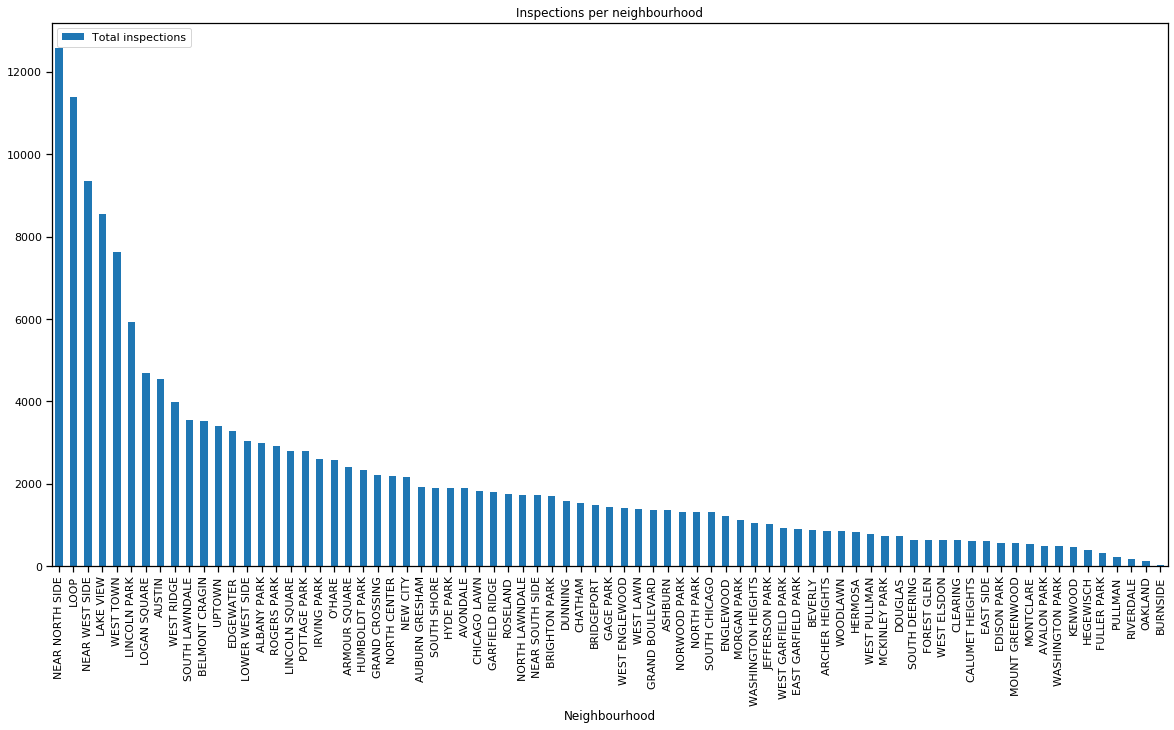

In [138]:
most_inspected_neighbourhoods = risks_per_hood_normalized.sort_values('Total inspections', axis=0, ascending=False)[['Total inspections']]
most_inspected_neighbourhoods.columns.rename('', inplace=True)
most_inspected_neighbourhoods.plot.bar(figsize=(20, 10), title='Inspections per neighbourhood').legend(loc='upper left')

In [139]:
risks_per_hood_normalized['RISK 1 (HIGH)'] = risks_per_hood_normalized['RISK 1 (HIGH)'] / risks_per_hood_normalized['Total inspections']
risks_per_hood_normalized['RISK 2 (MEDIUM)'] = risks_per_hood_normalized['RISK 2 (MEDIUM)'] / risks_per_hood_normalized['Total inspections']
risks_per_hood_normalized['RISK 3 (LOW)'] = risks_per_hood_normalized['RISK 3 (LOW)'] / risks_per_hood_normalized['Total inspections']
risks_per_hood_normalized.drop('Total inspections', axis=1, inplace=True)
risks_per_hood_normalized.sort_values(['RISK 1 (HIGH)', 'RISK 2 (MEDIUM)', 'RISK 3 (LOW)'], axis=0, ascending=False).head()

Risk,RISK 1 (HIGH),RISK 2 (MEDIUM),RISK 3 (LOW)
Neighbourhood,,,
BURNSIDE,1.000000,0.000000,0.000000
NORWOOD PARK,0.847777,0.097212,0.055011
EDISON PARK,0.837545,0.128159,0.034296
NEAR NORTH SIDE,0.820960,0.133445,0.045596
FOREST GLEN,0.818885,0.097523,0.083591


In [143]:
# We store it sorted in ascending fashion to have nicer plots.
risks_per_hood_normalized = risks_per_hood_normalized.sort_values(['RISK 1 (HIGH)', 'RISK 2 (MEDIUM)', 'RISK 3 (LOW)'], axis=0, ascending=False)

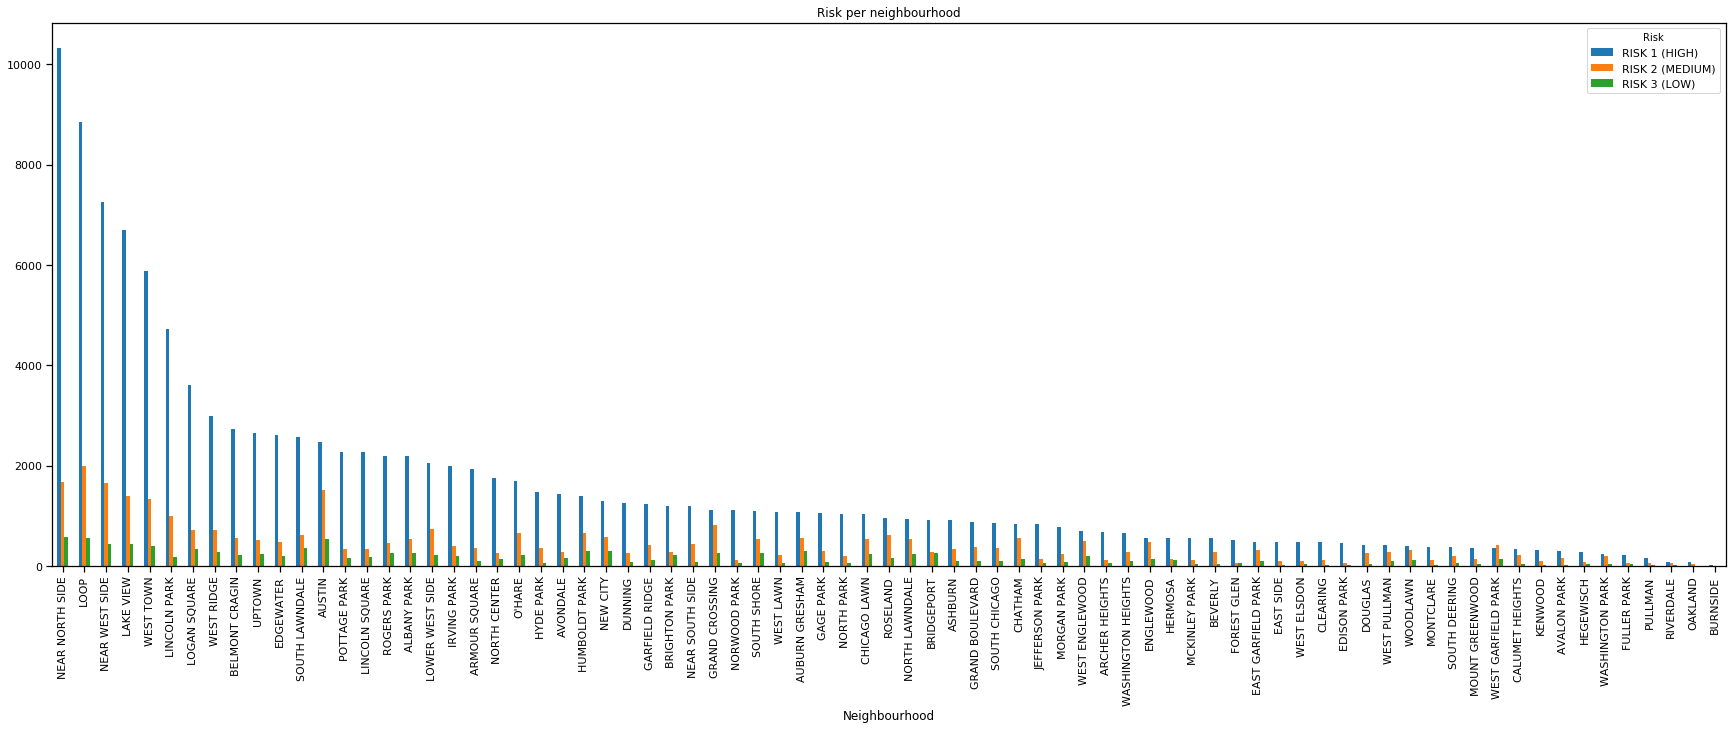

In [141]:
risks_per_hood.plot.bar(figsize=(30, 10), title='Risk per neighbourhood')

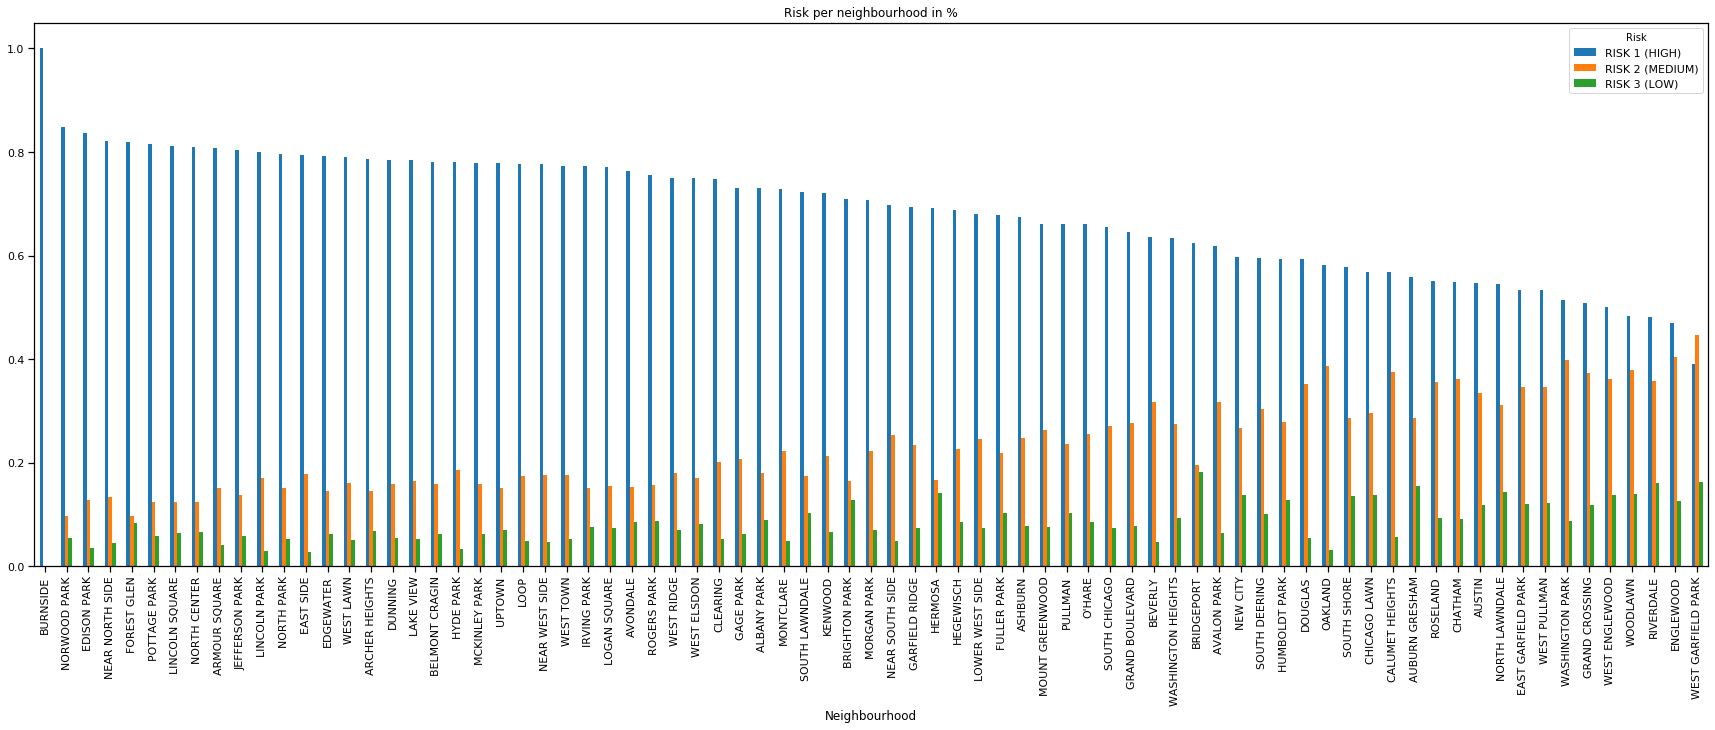

In [144]:
risks_per_hood_normalized.plot.bar(figsize=(30, 10), title='Risk per neighbourhood in %')

The top 5 is made of the following neighbourhoods, being also the most inspected ones:
1. **Near North Side**: 82% of all facilities are associated to the highest risk
2. **Loop**
3. **Near West Side**
4. **Lake View**
5. **West Town**

If we consider in the rankings also the total number of inspected facilities per neighbourhood, the top 5 changes:
1. **Burnside**: all the 19 facilities located in this neighbourhood have been labeled as high risk
2. **Norwood Park**
3. **Edison Park**
4. **Near North Side**
5. **Forest Glen**

We will use the [Chicago Metropolitan Agency for Planning website](https://www.cmap.illinois.gov/data/community-snapshots) to interpret these results in our data story, as they provide community snapshoots that summarize demographics, housing, employment, transportation habits, retail sales, property values, and land use in all 77 Chicago Community Areas, which correspond to the "neighbourhoods" we are considering.

### What is the most encountered violation category for each neighbourhood?

We first have to join the two dataframes to relate violations to inspections:

In [94]:
df_joined = df.join(df_violations)

Then, we compute the most encountered violation for each neighbourhood

In [95]:
most_encountered_violations = df_joined.groupby(['Neighbourhood'])['Violation'] \
                                        .agg(lambda x: x.value_counts().idxmax()).to_frame()

In [96]:
show_all(most_encountered_violations)

                                                            Violation
Neighbourhood                                                        
ALBANY PARK         34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
ARCHER HEIGHTS      32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...
ARMOUR SQUARE       34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
ASHBURN             35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...
AUBURN GRESHAM      34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
AUSTIN              34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
AVALON PARK         34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
AVONDALE            34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
BELMONT CRAGIN      34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
BEVERLY             34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
BRIDGEPORT          34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
BRIGHTON PARK       35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...
BURNSIDE            

In [97]:
most_encountered_violations['Violation'].value_counts().to_frame().rename(columns={'Violation': 'Occurrences'})

,Occurrences
"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED",54
"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS",16
"33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS",3
"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",2
38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED,2


Interesting enough, the most encountered violation category in each neighbourhood is, most of the times, `34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED`. 

It appears that the most difficult thing for the Chicago facilities is usually to keep their cooking and serving space (floors, walls and ceilings) clean and in good condition, whatever the neighbourhood they are located in.

## Violation analysis

<a id="violation"></a>

### What are the frequencies of each violation?

In [146]:
def violation_freq(df_freq):
    '''
    Returns the frequency of each violation for the given dataframe.
    :param df_occ: pandas.DataFrame, the given dataframe
    :return: pandas.DataFrame, the frequency of each violation sort by descending order
    '''
    
    df_occ = df_freq[['Violation', 'Comment']].groupby('Violation').count().rename(columns={'Comment': 'Frequency'})
    df_occ = df_occ / df_occ.sum(axis=0) * 100
    
    return df_occ.sort_values(by='Frequency', ascending=False)

In [147]:
df_violation_freq = violation_freq(df_violations)
df_violation_freq.head(10)

,Frequency
Violation,
"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED",13.755752
"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS",12.402528
"33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS",12.068420
"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",10.514461
38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED,10.371823
"41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING EQUIPMENT PROPERLY STORED",6.385689
"36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED",4.916077
"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS",3.250170
"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED",3.126255


As we could expect from the results of the previous question, the most frequent violations are related to the facilities' neatness and maintenance, especially regarding the floors, the walls and the equipments.

### Are some violations more frequent than others in an establishment’s failure?

In [148]:
df_fail = df[df['Results'] == 'FAIL']
df_fail = df_fail.join(df_violations, how='inner')
df_fail_violation_freq = violation_freq(df_fail)
df_fail_violation_freq[df_fail_violation_freq['Frequency'] > 0].head(10)

,Frequency
Violation,
"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED",10.630128
"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS",10.009904
"33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS",9.031155
"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS",9.012897
38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED,8.515500
"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",8.242734
"41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING EQUIPMENT PROPERLY STORED",5.847594
"36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED",4.245855
29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-090,3.050774


In [150]:
df_violation_freq_diff = (df_fail_violation_freq - df_violation_freq).sort_values(by='Frequency', ascending=False)
df_violation_freq_diff.head().append(df_violation_freq_diff.tail())

,Frequency
Violation,
"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS",5.762727
29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-090,1.878405
"19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE AREA; CLEAN, RODENT PROOF, ALL CONTAINERS COVERED",1.307866
"16. FOOD PROTECTED DURING STORAGE, PREPARATION, DISPLAY, SERVICE AND TRANSPORTATION",1.061223
"24. DISH WASHING FACILITIES: PROPERLY DESIGNED, CONSTRUCTED, MAINTAINED, INSTALLED, LOCATED AND OPERATED",1.023466
38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED,-1.856323
"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",-2.271727
"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS",-2.392624
"33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS",-3.037265


The really obvious observation from these computations is that violation 18 (`18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS`) has a significantly higher frequency in failed inspections. We can then deduce that the presence of rodents or insects is a serious misconduct and highly increases the inspection's failure probability.

### What are the most frequent violations encountered during complaint-caused inspections?

In [153]:
df_complaints_violation_freq = violation_freq(df[df['Inspection Type'] == 'COMPLAINT'].join(df_violations, how='inner'))
df_complaints_violation_freq.head(10)

,Frequency
Violation,
"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED",13.695456
"33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS",12.229930
"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS",11.320430
"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",9.727812
38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED,8.719021
"41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING EQUIPMENT PROPERLY STORED",5.888583
"36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED",4.584569
"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS",4.131805
"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED",3.179941


In [154]:
df_violation_freq_diff = (df_complaints_violation_freq - df_violation_freq).sort_values(by='Frequency', ascending=False)
df_violation_freq_diff.head().append(df_violation_freq_diff.tail())

,Frequency
Violation,
"3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE",1.303527
"18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS",0.881635
29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-090,0.524834
"6. HANDS WASHED AND CLEANED, GOOD HYGIENIC PRACTICES; NO BARE HAND CONTACT WITH READY-TO-EAT FOODS.",0.390000
"16. FOOD PROTECTED DURING STORAGE, PREPARATION, DISPLAY, SERVICE AND TRANSPORTATION",0.268868
37. TOILET ROOM DOORS SELF CLOSING: DRESSING ROOMS WITH LOCKERS PROVIDED: COMPLETE SEPARATION FROM LIVING/SLEEPING QUARTERS,-0.359283
"41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING EQUIPMENT PROPERLY STORED",-0.497106
"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED",-0.786649
"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS",-1.082098


Here the frequency difference is not really meaningful and we see that there is no link between complaint-based inspections and violations. Nevertheless we can still notice that clients tend to complain more about violation 3 (`3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE`), probably because this aspect is more visible to them.

# What comes next

Our idea is to generate a map with an evolution of the inspections throughout time. A more detailed planning is available in the README file.